<a href="https://colab.research.google.com/github/BiancaMMoreno/Artgan-Implementation/blob/master/INF554_AutoEncoder_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/INF554/project'
%ls

Mounted at /content/drive
/content/drive/My Drive/INF554/project
baseline.py               data/              mean_predictions.txt
constant_predictions.txt  dummy_baseline.py


## Import libraries


In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import * 

## Open dataset

In [3]:
data_path = "data" # main path to our dataset
train_path = os.path.join(data_path, 'train.csv')
eval_path = os.path.join(data_path, 'evaluation.csv')

In [4]:
train_df = pd.read_csv(train_path, index_col='id')
eval_df = pd.read_csv(eval_path, index_col='id')

## Data visualization

In [5]:
eval_df.head()

,timestamp,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
id,,,,,,,,,
665776,1588644489777,False,229,36,99,NaN,NaN,NaN,"Coronavirus, no spring break, Chris Brown fan ..."
665777,1588463988413,True,106991,41273,326,NaN,NaN,NaN,This fits the data.
665778,1588563932106,False,24127,345,200,NaN,NaN,NaN,Y’all talk about the Coronavirus like y’all be...
665779,1588639210045,True,771,6555,83,NaN,twitter.com/i/web/status/1…,NaN,"As this coronavirus and covid-19 go on, the fo..."
665780,1588692867357,False,32595,6490,1206,NaN,vice.com/en_us/article/…,NaN,Big Brother is not very good at watching you. ...


## Data transformation

### timestamp

For this column, we split into 24 columns based on intervals of one hour per day equivalent to the time of tweets. These columns will have boolean values (0 or 1), being 1 if the tweet was posted in that interval, 0 if not.

In [6]:
def transform_timestamp(df):
  if 'timestamp' not in df:
    raise Exception("'timestamp' column not found in the dataframe")
  # we must divide by 1000 to transform into ms
  df['time'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp']/ 1000).hour, axis=1)
  new_c = {i: '{} - {}'.format(i, i + 1) for i in range(24)}
  dummies = pd.get_dummies(df['time'])
  dummies = dummies.rename(columns=new_c)
  df = df.drop(['timestamp', 'time'], axis=1)
  return pd.concat([df, dummies], axis=1, join='inner')
train_df = transform_timestamp(train_df)
eval_df = transform_timestamp(eval_df)

### user_verified

Transform into 0 and 1 values

In [7]:
def transform_user_verified(df):
  if 'user_verified' not in df:
    raise Exception("'user_verified' column not found in the dataframe")
  df['user_verified'] *= 1
  return df
train_df = transform_user_verified(train_df)
eval_df = transform_user_verified(eval_df)

### user_statuses_count, user_followers_count, user_friends_count

Normalize our values

In [8]:
def normalize(df, column, mean=None, std=None):
  # column: name of the column
  # mean: Optional, used to normalize test dataframe
  # std: Optional, used to normalize test dataframe
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  if mean is None and std is None:
    # train dataset
    mean = df[column].mean()
    std = df[column].std()
    df[column] = (df[column] - mean) / std
  else:
    df[column] = (df[column] - mean) / std
  return df, mean, std
train_df, mean, std = normalize(train_df, 'user_statuses_count')
eval_df, _, _ = normalize(eval_df, 'user_statuses_count', mean, std)
train_df, mean, std = normalize(train_df, 'user_followers_count')
eval_df, _, _ = normalize(eval_df, 'user_followers_count', mean, std)
train_df, mean, std = normalize(train_df, 'user_friends_count')
eval_df, _, _ = normalize(eval_df, 'user_friends_count', mean, std)

### user_mentions

Count the number of mentions and normalize our values

In [9]:
def count_and_normalize(df, column, mean=None, std=None):
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  df = df.copy()
  df[column].fillna("", inplace=True)
  df[column] = df.apply(lambda x: 0 if x[column] == "" else len(x[column].split(",")), axis=1)
  return df, mean, std
  # return normalize(df, column, mean=mean, std=std)
train_df, mean, std = count_and_normalize(train_df, 'user_mentions')
eval_df, _, _ = count_and_normalize(eval_df, 'user_mentions', mean, std)

### urls

Transform into a boolean value (0 if there isn't a url, 1 if there is)

In [10]:
def transform_urls(df):
  if 'urls' not in df:
    raise Exception("'{}' column not found in the dataframe".format('urls'))
  df = df.copy()
  df["urls"] = df.apply(lambda x: 0 if x["urls"] != x["urls"] else 1, axis=1)
  return df 
train_df = transform_urls(train_df)
eval_df = transform_urls(eval_df)

### hashtags

Count the number of hashtags and normalize our values

In [11]:
train_df, mean, std = count_and_normalize(train_df, 'hashtags')
eval_df, _, _ = count_and_normalize(eval_df, 'hashtags', mean, std)

### text

Drop this column for now

In [12]:
train_df = train_df.drop(['text'], axis=1)
eval_df = eval_df.drop(['text'], axis=1)

### retweet_count

Our Y values, we will perform a normalisation and save mean and standard deviation value.

In [13]:
train_df, mean_y, std_y = normalize(train_df, 'retweet_count')

## Feature analysis


**PCA**


Let's try to make a PCA. It's probably better to drop the time column.


In [14]:
df_time = train_df.iloc[:, 0:8]
df_time.head()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags
id,,,,,,,,
0,-0.049692,0,0.271991,-0.094948,-0.087929,0,0,0
1,-0.049692,0,-0.420002,-0.095378,-0.147277,0,0,0
2,-0.049692,0,-0.390231,-0.094713,-0.024234,0,0,0
3,-0.049692,0,-0.094897,-0.095125,-0.141365,0,0,0
4,-0.049692,0,-0.417240,-0.095381,-0.151624,0,0,0


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df_time)
pca_values=pca.components_

# We print the explained variance ratio
print(pca.explained_variance_ratio_)

[0.25476696 0.20239095 0.17703703 0.14955836 0.10478533 0.06270087
 0.03410965 0.01465085]


Let's make the scree plot to see the explained variance by each dimension

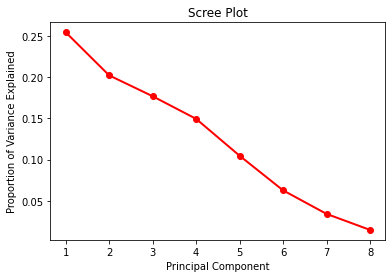

In [16]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


Let's try to visualize our original parameters in this new base


In [17]:
columns=train_df.columns.values # to name the vectors

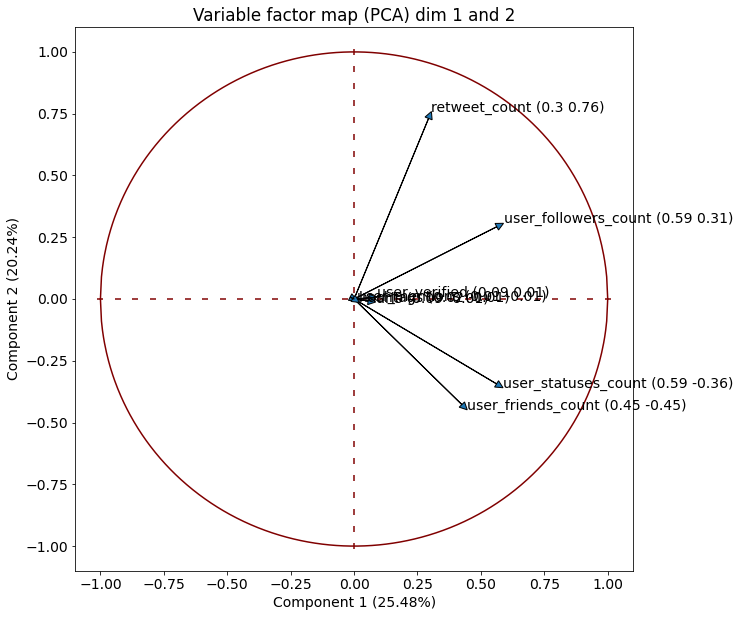

In [18]:

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})

#Plot circle
#Create a list of 500 points with equal spacing between -1 and 1
x=np.linspace(start=-1,stop=1,num=500)
#Find y1 and y2 for these points
y_positive=lambda x: np.sqrt(1-x**2) 
y_negative=lambda x: -np.sqrt(1-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')

#Create broken lines
x=np.linspace(start=-1,stop=1,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='maroon')
plt.scatter([0]*len(x), x, marker='|',color='maroon')

add_string=""
for i in range(len(pca_values[0])):
    xi=pca_values[0][i]
    yi=pca_values[1][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.03, 
              length_includes_head=True)
    add_string=f" ({round(xi,2)} {round(yi,2)})"
    plt.text(pca_values[0, i], 
             pca_values[1, i] , 
             s=columns[i] + add_string )
    
plt.xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
plt.ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
plt.title('Variable factor map (PCA) dim 1 and 2')
plt.show()

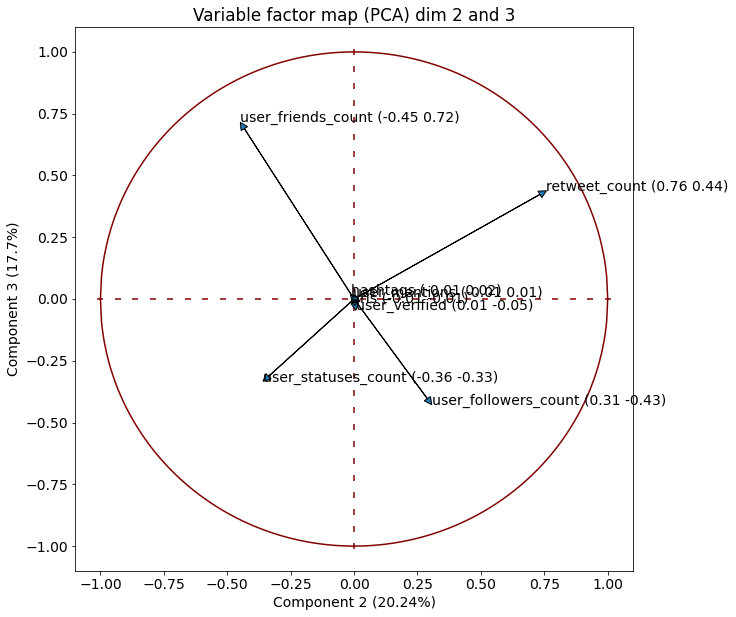

In [19]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})

#Plot circle
#Create a list of 500 points with equal spacing between -1 and 1
x=np.linspace(start=-1,stop=1,num=500)
#Find y1 and y2 for these points
y_positive=lambda x: np.sqrt(1-x**2) 
y_negative=lambda x: -np.sqrt(1-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')

#Create broken lines
x=np.linspace(start=-1,stop=1,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='maroon')
plt.scatter([0]*len(x), x, marker='|',color='maroon')

add_string=""
for i in range(len(pca_values[0])):
    xi=pca_values[1][i]
    yi=pca_values[2][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.03, 
              length_includes_head=True)
    add_string=f" ({round(xi,2)} {round(yi,2)})"
    plt.text(pca_values[1, i], 
             pca_values[2, i] , 
             s=columns[i] + add_string )
    
plt.xlabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
plt.ylabel(f"Component 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)")
plt.title('Variable factor map (PCA) dim 2 and 3')
plt.show()

**AutoEncoder**

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class AutoEncoder(nn.Module):
   
     def __init__(self, input_shape, hidden_shape, embedding_shape):
     
         super(AutoEncoder, self).__init__()
         
         self.encoder = nn.Sequential(
             nn.Linear(input_shape,hidden_shape),
             nn.ReLU(True),
             nn.Linear(hidden_shape,embedding_shape),
             nn.ReLU(True))
             
         self.decoder = nn.Sequential(             
             nn.Linear(embedding_shape,hidden_shape),
             nn.ReLU(True),
             nn.Linear(hidden_shape,input_shape),
             nn.ReLU(True))
             
     def forward(self,x):
         x = self.encoder(x)
         x = self.decoder(x)
         return x


# Remove retweet column to train on the autoencoder
X_df = train_df.drop(['retweet_count'], axis=1)

# Split data into train and val
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X_df, test_size= 0.2)
X_val_torch = torch.tensor(X_val.values).float()

# Model for the autoencoder
model_AE = AutoEncoder(input_shape=31,hidden_shape=15,embedding_shape=5)

# Optimizer we will use to train it
optimizer_AE = torch.optim.Adam(model_AE.parameters())

# Loss to train it
criterion_AE = nn.MSELoss()

# We use only the train data without the number of retweets
train_loader = torch.utils.data.DataLoader(
    torch.tensor(X_train.values).float(), 
     batch_size=100
)


In [55]:
def train_AE(train_loader,data_val,model,criterion,optimizer,epochs=10):

  # Create vector to save loss
  loss_epoch = []
  loss_val_epoch = []

  for epoch in range(epochs):
    loss = 0

    for data_batchs in train_loader:

      # Reset gradients back to zero
      optimizer.zero_grad()

      # Compute the reconstruction
      outputs = model(data_batchs)

      # Compute loss 
      train_loss = criterion(outputs,data_batchs)

      # Calculate gradients
      train_loss.backward()

      # Update parameteres
      optimizer.step()

      loss += train_loss.item()

    # Store the mean training loss on epoch
    loss = loss/len(train_loader)
    loss_epoch.append(loss)

    # Compute loss on validation set
    output = model(data_val)
    val_loss = criterion(output,data_val)

    # Store the validation loss on epoch 
    loss_val_epoch.append(val_loss.item())

    # Display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}, val_loss = {:.6f}".format(epoch + 1, epochs, loss,val_loss))


train_AE(train_loader,X_val_torch,model_AE,criterion_AE,optimizer_AE)

epoch : 1/10, train_loss = 0.057964, val_loss = 0.045612
epoch : 2/10, train_loss = 0.045124, val_loss = 0.045116
epoch : 3/10, train_loss = 0.044580, val_loss = 0.044321
epoch : 4/10, train_loss = 0.044369, val_loss = 0.044170
epoch : 5/10, train_loss = 0.044196, val_loss = 0.044001
epoch : 6/10, train_loss = 0.044115, val_loss = 0.044073
epoch : 7/10, train_loss = 0.039345, val_loss = 0.035796
epoch : 8/10, train_loss = 0.035526, val_loss = 0.035434
epoch : 9/10, train_loss = 0.035307, val_loss = 0.035315
epoch : 10/10, train_loss = 0.035263, val_loss = 0.035655


## Data preparation

In this part, we will transform our train_df into X and Y to train our models. 20% of our values will be used to test our model.

In [36]:
# train dataset
train_df.head()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.049692,0,0.271991,-0.094948,-0.087929,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.049692,0,-0.420002,-0.095378,-0.147277,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.049692,0,-0.390231,-0.094713,-0.024234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.049692,0,-0.094897,-0.095125,-0.141365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,-0.049692,0,-0.417240,-0.095381,-0.151624,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.model_selection import train_test_split

y = train_df['retweet_count'].to_numpy()
X_df = train_df.drop(['retweet_count'], axis=1)
X = X_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model

- NN: (31, 15, 5, 1)
- Activation functions: (ReLu, ReLu, Linear)
- L1 Loss

In [22]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(31, 15)
        self.l2 = torch.nn.Linear(15, 5)
        self.l3 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
  
class TweetDataSet(Dataset):
    def __init__(self, X, y, device, mode='Train'):                 
      self.X = X
      self.y = y
      self.mode = mode
      self.device = device

    def __len__(self):
      return len(self.X)
    
    def __getitem__(self, idx):
      x_g = self.X[idx]
      if self.mode == 'Train' or self.mode == "Test":
        y_g = np.expand_dims(self.y[idx], axis=0)
        return torch.from_numpy(x_g).type(torch.cuda.FloatTensor), torch.from_numpy(y_g).float().type(torch.cuda.FloatTensor)
      else:
        return torch.from_numpy(x_g).float().type(torch.cuda.FloatTensor), None

In [28]:
model = Net()
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()

epochs = 10

train_dataset = TweetDataSet(X_train, y_train, torch.device('cuda'))
test_dataset = TweetDataSet(X_test, y_test, torch.device('cuda'), mode='Test')

__main__.TweetDataSet


In [ ]:
def train_epoch(model, opt, loss_func, trainloader):
  model.train()
  losses = []
  for x_batch, y_batch in tqdm(trainloader, total=len(trainloader)):
      # x_batch = x_batch.type(torch.cuda.FloatTensor)
      opt.zero_grad()
      # Forward
      y_comp = model(x_batch)
      # Compute diff
      loss = loss_func(y_comp.cpu(), y_batch.cpu())
      # Compute gradients
      loss.backward()
      # update weights
      opt.step()
      losses.append(loss.data.numpy())
  return losses

def accuracy(model, testloader):
  model.eval()
  total = 0
  div = 0
  for x_batch, y_batch in tqdm(testloader, total=len(testloader)):
      outputs = model(x_batch)
      total += torch.abs(outputs - y_batch).sum().item()
      div += outputs.size(0)
  model.train()
  return total / div

def train(train_dataset, test_dataset, model, loss_func, opt, epochs, bs=100):
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs)
  loss_train = []
  loss_test = []
  for i in range(epochs):
    loss_train_epoch = train_epoch(model, opt, loss_func, train_dataloader)
    loss_train.append(sum(loss_train_epoch)/(len(loss_train_epoch)*bs))
    print('epoch {}, loss train {}'.format(i + 1, sum(loss_train_epoch)/(len(loss_train_epoch)*bs)))
    loss_test_epoch = accuracy(model, test_dataloader)
    print('epoch {}, loss test {}'.format(i + 1, loss_test_epoch))
    loss_test.append(loss_test_epoch)
  return loss_train, loss_test

In [ ]:
loss_train, loss_test = train(train_dataset, test_dataset, model, loss_func, optimizer, epochs)


epoch 1, loss train 1.488153818768096



epoch 1, loss test 157.2199489193919



epoch 2, loss train 1.4545620757226136



epoch 2, loss test 157.15526895781767



epoch 3, loss train 1.452884430747912



epoch 3, loss test 157.148595886313



epoch 4, loss train 1.452862215719282



epoch 4, loss test 157.14903656641164



epoch 5, loss train 1.4529862055090146



epoch 5, loss test 157.15576240997694



epoch 6, loss train 1.453030700098177



epoch 6, loss test 157.15728238618092



epoch 7, loss train 1.4528644518537148



epoch 7, loss test 157.1567684919472



epoch 8, loss train 1.452906563140582



epoch 8, loss test 157.15548685290378



epoch 9, loss train 1.45301492284247



epoch 9, loss test 157.15389988635752



epoch 10, loss train 1.4528830794113672



epoch 10, loss test 157.14909895239404


## Evaluate our model

In [ ]:
X_eval = eval_df.to_numpy()
X_eval.shape

(285334, 31)

In [ ]:
eval_df.head()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
665776,0,229,36,99,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
665777,1,106991,41273,326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
665778,0,24127,345,200,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
665779,1,771,6555,83,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
665780,0,32595,6490,1206,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
model.eval()
y_eval = model(torch.from_numpy(X_eval).type(torch.cuda.FloatTensor))
y_eval = y_eval.cpu().detach().numpy()
y_eval = y_eval * std_y + mean_y
y_eval = y_eval.T[0]
y_eval = np.array([0 if y_eval[i] < 0 else int(y_eval[i]) for i in range(len(y_eval))])    

In [ ]:
import csv
# Dump the results into a file that follows the required Kaggle template
result = pd.DataFrame()
result['TweetID'] = eval_df.index
result['NoRetweets'] = y_eval
with open("prediction.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for idx, row in result.iterrows():
      id = str(row['TweetID'])
      num =  str(int(row['NoRetweets']))
      writer.writerow([id, num])

In [ ]:
from collections import Counter
Counter(y_eval)

Counter({0: 242302, 1: 38996, 2: 3363, 3: 543, 4: 128, 5: 2})